In [1]:
#Packages needed
using Optim
using Plots
using StatsBase
using Distributions
using Statistics
using Random
using JuMP, Gurobi, GLPK
using TickTock
using Distributed
using CSV
using DataFrames
using JLD2
using Dates
using FileIO

In [2]:
### this only loads backorders and total cost
function load_many_files(adi, cv2, folderpath, demlevel, starterstring, dates)
    #if length(adi) != length(cv2) || length(adi) != length(starterstring) || length(adi) != length(dates)
        #error("ERROR: Length of ADI is not the same as CV2, starterstring, or dates. Edit Accordingly")
    #end
    
    adistr = replace(string(adi[1]),"." => "_")
    cv2str = replace(string(cv2[1]),"." => "_")
    path = folderpath * dates[1] * "_" * starterstring * "_" * adistr * "ADI_" * cv2str * "CV2_" * string(demlevel) *"AvgDem.jld2"
    file = FileIO.load(path)
    BO = file["BOtot"][:,1,1,1,1]
    BOstdev = file["BOstdev"]
    TC = file["TC"]
    TCstd = file["TCstdev"]
    little_s = file["little_s"]
    big_S = permutedims(file["Big_S"],[1,3,2])[:,:,1]
    AMprodCost = file["AMprodCost"]
    TMprodCost = file["TMprodCost"]
    SupTransCost = file["SupTransCost"]
    TMtransCost = file["TMtransCost"]
    InvCarCost = file["InvCarCost"]
    InvCarStd = file["InvCoststdev"]
    AMprodcoststdev = file["AMprodcoststdev"]
    Suptransstdev = file["Suptransstdev"]
    TMcoststdev = file["TMcoststdev"]
    TMtransstdev = file["TMtransstdev"]
    
    
    for i = 2:length(adi)
        adistr = replace(string(adi[i]),"." => "_")
        cv2str = replace(string(cv2[i]),"." => "_")
        path = folderpath * dates[i] * "_" * starterstring * "_" * adistr * "ADI_" * cv2str * "CV2_" * string(demlevel) *"AvgDem.jld2"
        file = FileIO.load(path)
        BO = hcat(BO, file["BOtot"][:,1,1,1,1])
        BOstdev = hcat(BOstdev,file["BOstdev"])
        TC = hcat(TC,file["TC"][:,1,1])
        little_s = hcat(little_s,file["little_s"])
        big_S = vcat(big_S, permutedims(file["Big_S"],[1,3,2])[:,:,1])
        AMprodCost = hcat(AMprodCost,file["AMprodCost"])
        TMprodCost = hcat(TMprodCost,file["TMprodCost"])
        SupTransCost = hcat(SupTransCost,file["SupTransCost"])
        TMtransCost = hcat(TMtransCost,file["TMtransCost"])
        InvCarCost = hcat(InvCarCost,file["InvCarCost"])
        InvCarStd = hcat(InvCarStd,file["InvCoststdev"])
        TCstd = hcat(TCstd,file["TCstdev"])
        AMprodcoststdev = hcat(AMprodcoststdev,file["AMprodcoststdev"])
        Suptransstdev = hcat(Suptransstdev,file["Suptransstdev"])
        TMcoststdev = hcat(TMcoststdev,file["TMcoststdev"])
        TMtransstdev = hcat(TMtransstdev,file["TMtransstdev"])
    end
    return BO, TC, little_s, big_S, BOstdev, TCstd, AMprodCost, TMprodCost, SupTransCost, TMtransCost, InvCarCost, InvCarStd, AMprodcoststdev, Suptransstdev, TMcoststdev, TMtransstdev 
end

load_many_files (generic function with 1 method)

In [3]:
currentpath = pwd()
starter = "114_redo_6AMCap"
date1 = "\\2021-11-16"
dates = repeat([date1],20)
adi = repeat([3],20)
cv2 = [0.25:0.25:5;]
dem = 3

3

In [4]:
adistr = replace(string(adi[1]),"." => "_")
    cv2str = replace(string(cv2[1]),"." => "_")
    path = currentpath * dates[1] * "_" * starter * "_" * adistr * "ADI_" * cv2str * "CV2_" * string(dem) *"AvgDem.jld2"
    file = FileIO.load(path)

Dict{String, Any} with 19 entries:
  "BOstdev"         => [36.5151; 8.72842; … ; 11.7029; 12.7501]
  "AMprodCost"      => [0.0; 12.234; … ; 44.21; 44.796]
  "Suptransstdev"   => [148.43; 128.632; … ; 167.045; 176.269]
  "AMprodcoststdev" => [0.0; 8.12572; … ; 5.66092; 5.837]
  "BO_by_SL"        => [3.982 5.802 8.926 14.122; 0.022 0.482 1.666 3.362; … ; …
  "TMprodCost"      => [190.726; 177.912; … ; 144.728; 146.086]
  "Big_S"           => [47.0]…
  "little_s"        => [30.0]
  "TMcoststdev"     => [11.6672; 12.7584; … ; 11.4684; 12.3057]
  "SupTransCost"    => [4520.65; 4534.25; … ; 3427.85; 3412.4]
  "TMtransCost"     => [4263.5; 3941.55; … ; 3216.65; 3246.55]
  "BOtot"           => [32.832; 5.532; … ; 6.4; 6.55]
  "InvCoststdev"    => [530.044; 400.866; … ; 429.188; 484.519]
  "InvCarCost"      => [4378.9; 4160.35; … ; 4707.59; 4886.56]
  "TCstdev"         => [710.758; 594.579; … ; 596.913; 677.491]
  "TMtransstdev"    => [444.579; 415.663; … ; 376.71; 391.252]
  "TC"              

In [5]:
BO, TC, little_s, big_S, BOstdev, TCstd, AMprodCost, TMprodCost, SupTransCost, TMtransCost, InvCarCost, InvCarStd, AMprodcoststdev, Suptransstdev, TMcoststdev, TMtransstdev  = load_many_files(adi,cv2,currentpath,dem,starter,dates)

([32.832 98.514 … 872.03 1817.384; 5.532 14.84 … 208.746 322.804; … ; 6.4 27.028 … 401.598 879.704; 6.55 25.256 … 389.522 875.836], [13353.772 11876.938 … 10000.152 6923.092; 20086.298 19144.834 … 17674.64 15537.686; … ; 18801.026 17778.07 … 16505.002 13975.53; 18996.388 17822.554 … 16499.744 13969.214], [30.0 30.0 … 26.0 17.0], [47.0 40.0 … 43.0 45.0; 30.0 30.0 … 30.0 30.0; … ; 26.0 26.0 … 26.0 26.0; 17.0 17.0 … 17.0 17.0], [36.51507191494915 93.99169474673134 … 572.0688863427577 913.1764248543758; 8.728421775635432 19.120606559164923 … 163.56618623223173 213.00034713530286; … ; 11.702902026064447 38.34135280176403 … 293.58915780928686 511.89210918600196; 12.750083500060578 35.408331843336754 … 295.8188416754084 522.6472207318023], [710.7575709518194 583.3157950798 … 973.0085900590278 731.3955389560491; 594.5789817400663 549.3253271733867 … 724.6955150814432 596.399446683184; … ; 596.9130352633746 525.0228176165642 … 840.2204608563655 730.2063898951359; 677.4914514512926 534.459439873

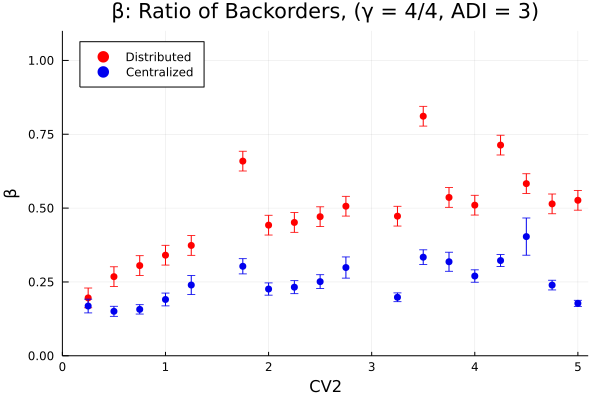

In [6]:
SLBO = mean(BO[4:7,:],dims=1)
SLBOstd = mean(BOstdev[4:7,:],dims=1)

function conf_int_error(num_real,std)
    error = 1.96 .* (std) / sqrt.(num_real)
    return error
end

SLerror = conf_int_error(500,SLBOstd) ./ BO[1,:]'
SLratio = SLBO ./ BO[1,:]'

DCerror = conf_int_error(500,BOstdev[2,:]) ./ BO[1,:]
DCratio = BO[2,:] ./ BO[1,:]

CV2 = [0.25:0.25:5]
scatter(CV2, SLratio', title = "β: Ratio of Backorders, (γ = 4/4, ADI = 3)",label = "Distributed",legend=:topleft,xlabel="CV2",ylabel= "β",
ylims=(0,1.1), xlims=(0,5.1), yerror=SLerror,color=:red,markerstrokecolor=:red,)
scatter!(CV2,DCratio, label="Centralized", yerror=DCerror,color=:blue2,markerstrokecolor=:blue2)

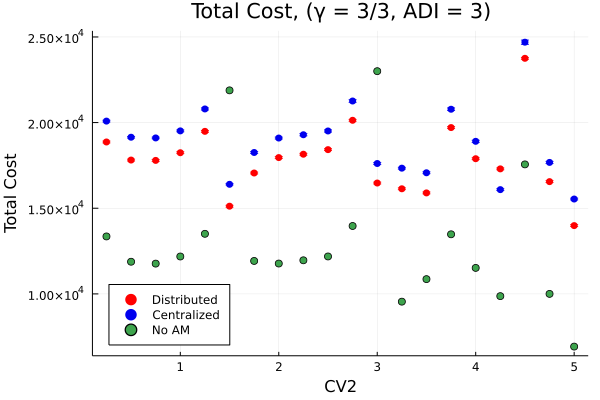

In [23]:
CV2 = [0.25:0.25:5]
function conf_int_error(num_real,std)
    error = 1.96 .* (std) / sqrt.(num_real)
    return error
end

SLerror = mean(conf_int_error(500,TCstd)[4:7,:],dims=1)
DCerror = conf_int_error(500,TCstd[2,:])


scatter(CV2, mean(TC[4:7,:],dims=1)', title = "Total Cost, (γ = 3/3, ADI = 3)",label = "Distributed",legend=:bottomleft,xlabel="CV2",ylabel= "Total Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,TC[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)
scatter!(CV2,TC[1,:],label="No AM")

In [8]:
(mean(TC[4:7,:],dims=1)' ./ TC[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
 -0.06531647355940218
 -0.05971050628856289
 -0.06471300356254206
 -0.053676807154770856
 -0.09984536950997724

In [9]:
SLerror

1×20 Matrix{Float64}:
 54.7301  45.8823  46.9794  52.0817  …  98.692  128.958  73.3045  64.711

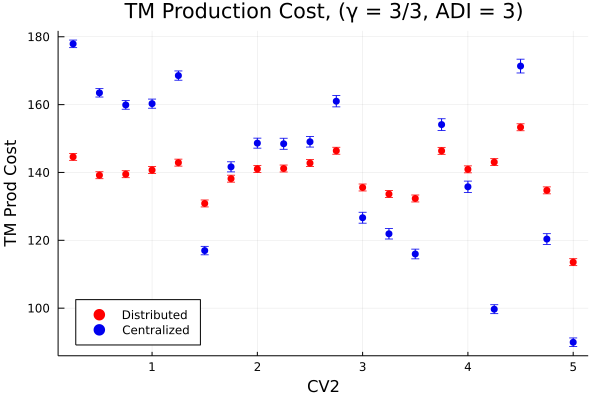

In [10]:
SLerror = mean(conf_int_error(500,TMcoststdev)[4:7,:],dims=1)
DCerror = conf_int_error(500,TMcoststdev[2,:])

scatter(CV2, mean(TMprodCost[4:7,:],dims=1)', title = "TM Production Cost, (γ = 3/3, ADI = 3)",label = "Distributed",legend=:bottomleft,xlabel="CV2",ylabel= "TM Prod Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,TMprodCost[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)

In [11]:
(mean(TMprodCost[4:7,:],dims=1)' ./ TMprodCost[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
 -0.12216600326915639
 -0.0511867439889131
  0.07037171551288512
  0.037833259684784126
  0.2625642109008428

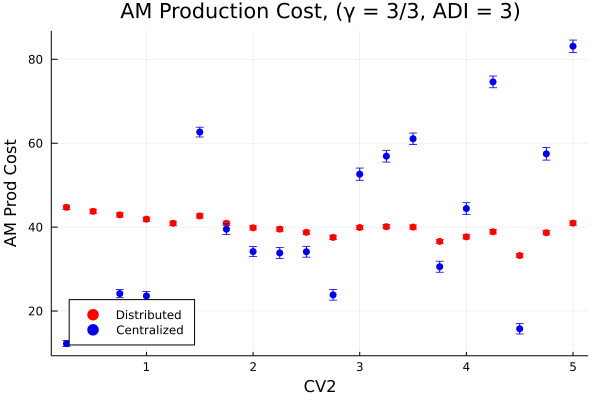

In [12]:
SLerror = mean(conf_int_error(500,AMprodcoststdev)[4:7,:],dims=1)
DCerror = conf_int_error(500,AMprodcoststdev[2,:])


scatter(CV2, mean(AMprodCost[4:7,:],dims=1)', title = "AM Production Cost, (γ = 3/3, ADI = 3)",label = "Distributed",legend=:bottomleft,xlabel="CV2",ylabel= "AM Prod Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,AMprodCost[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)

In [13]:
(mean(AMprodCost[4:7,:],dims=1)' ./ AMprodCost[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
  0.7750402508262011
  0.165818117977528
 -0.24168661878159092
 -0.15196453485755435
 -0.5073087102983638

In [14]:
SLerror

1×20 Matrix{Float64}:
 0.505354  0.480529  0.460729  0.464671  …  0.555322  0.565302  0.579425

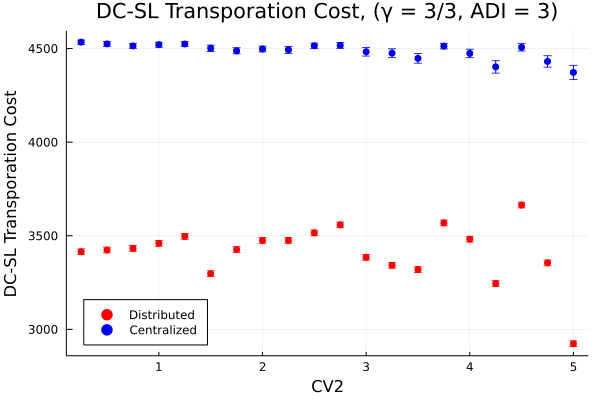

In [15]:
SLerror = mean(conf_int_error(500,Suptransstdev)[4:7,:],dims=1)
DCerror = conf_int_error(500,Suptransstdev[2,:])


scatter(CV2, mean(SupTransCost[4:7,:],dims=1)', title = "DC-SL Transporation Cost, (γ = 3/3, ADI = 3)",label = "Distributed",legend=:bottomleft,xlabel="CV2",ylabel= "DC-SL Transporation Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,SupTransCost[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)

In [16]:
(mean(SupTransCost[4:7,:],dims=1)' ./ SupTransCost[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
 -0.23474517220784386
 -0.22734725865978922
 -0.24493938413838479
 -0.22176838058625659
 -0.3314523229620482

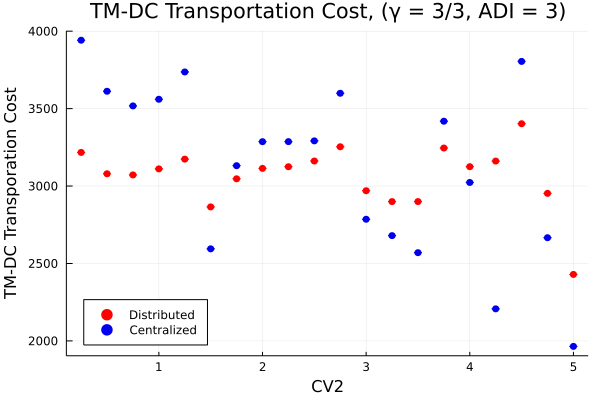

In [17]:
SLerror = mean(conf_int_error(500,TMcoststdev)[4:7,:],dims=1)
DCerror = conf_int_error(500,TMcoststdev[2,:])


scatter(CV2, mean(TMtransCost[4:7,:],dims=1)', title = "TM-DC Transportation Cost, (γ = 3/3, ADI = 3)",label = "Distributed",legend=:bottomleft,xlabel="CV2",ylabel= "TM-DC Transporation Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,TMtransCost[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)

In [18]:
(mean(TMtransCost[4:7,:],dims=1)' ./ TMtransCost[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
 -0.12627269790891338
 -0.05245401573126007
  0.06611918865553768
  0.03372421891798005
  0.23659930260378226

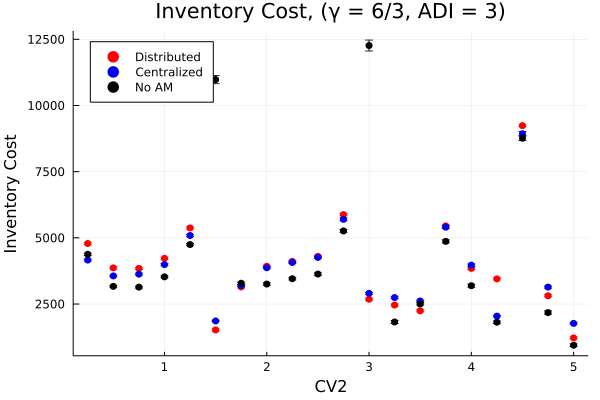

In [24]:
SLerror = mean(conf_int_error(500,InvCarStd)[4:7,:],dims=1)
DCerror = conf_int_error(500,InvCarStd[2,:])
NOerror = conf_int_error(500,InvCarStd[1,:])


scatter(CV2, mean(InvCarCost[4:7,:],dims=1)', title = "Inventory Cost, (γ = 6/3, ADI = 3)",label = "Distributed",legend=:topleft,xlabel="CV2",ylabel= "Inventory Cost",
color=:red,markerstrokecolor=:red,yerror=SLerror)
scatter!(CV2,InvCarCost[2,:], label="Centralized",color=:blue2,markerstrokecolor=:blue2,yerror=DCerror)
scatter!(CV2, InvCarCost[1,:],color=:black,label="No AM",yerror=NOerror)

In [20]:
(mean(InvCarCost[4:7,:],dims=1)' ./ InvCarCost[2,:] .- 1)[[4,8,12,16,20],:]

5×1 Matrix{Float64}:
  0.059491518288080636
  0.014612395229909092
 -0.07644652866189383
 -0.030975805915184673
 -0.3101933887327386

In [21]:
hcat((mean(InvCarCost[4:7,:],dims=1)'.-SLerror'),((mean(InvCarCost[4:7,:],dims=1)'.+SLerror')))[[4,8,12,16,20],:]

5×2 Matrix{Float64}:
 4192.88  4262.85
 3886.48  3967.87
 2640.23  2722.09
 3798.76  3893.17
 1170.29  1268.21

In [22]:
hcat(InvCarCost[2,:].-DCerror,InvCarCost[2,:].+DCerror)[[4,8,12,16,20],:]

5×2 Matrix{Float64}:
 3951.87  4029.07
 3833.77  3907.46
 2867.84  2938.34
 3925.6   4012.2
 1742.39  1792.67